# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

#### Прочитаем данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')

#### Первые 5 строк таблицы

In [3]:
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Общая информация о полученном датафрейме.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### Общие гистограммы для всех столбцов таблицы

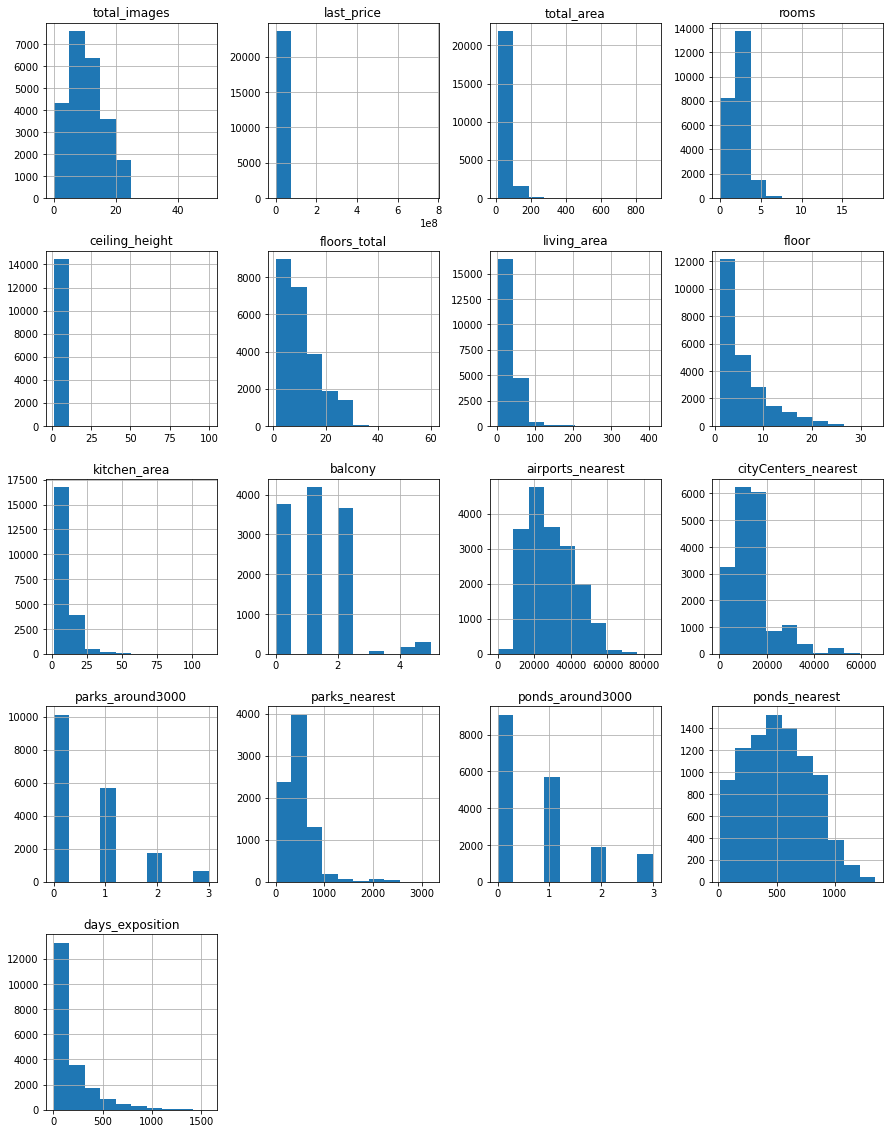

In [5]:
data.hist(figsize=(15, 20));

Промежуточный вывод: 
- В таблице присутсвуют пропуски;
- При первичном построении гистограмм по полученным данным видно, что имеется неравновмерное распределение данных;
- Практически во всех данных за исключением некторых(балкон, парки рядом, пруды рядом), есть анамально большие значения, которые следует убрать.

### Предобработка данных

#### Удаление пропусков

Количество пропущенных значений для каждого столбцам

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

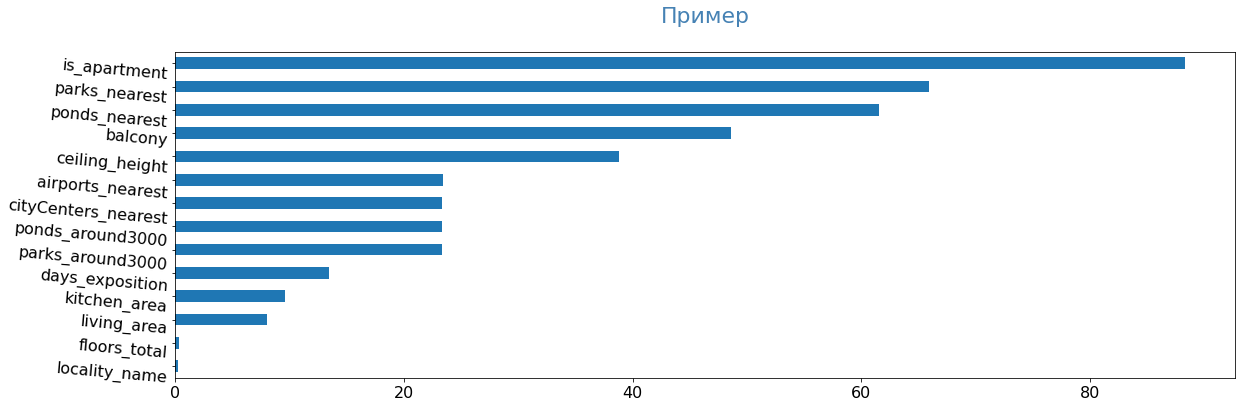

In [8]:
pass_value_barh(data)

##### Пропуски столбца 'balcony'.

Там, где не указано значение по умолчанию поставим 0.

In [9]:
data['balcony'] = data['balcony'].fillna(value=0)

##### Пропуски столбца площадь кухни 'kitchen_area':
- если квартира студия, то площадь равна 0.
- если квартира не студия, то медианным значением.

In [10]:
# площадь кухни в студии 0
data.loc[data['studio']==True, 'kitchen_area'] = 0
#посчитаем медиану площади кухни
kitchen_area_median = data['kitchen_area'].median()
#заполним пропуски в площади кухни медианным занчением
data['kitchen_area']=data['kitchen_area'].fillna(value=kitchen_area_median)

##### Пропуски в столбце жилая площадь 'living_area'.

Сделаем предположение что сумму жилой площади living_area и площади кухни kitchen_area не превышаем общей плошади total_area. С учетом того, что у нас есть еще другие помещения, такие как коридоры, сан.узлы, балконы  - примем 'living_area' = 0.9*'total_area'-'kitchen_area'

In [11]:
# #посчитем мидиану общих площадей 'total_area'
# total_area_median = data['total_area'].median()
# #посчитем мидиану жилых площадей 'living_area'
# living_area_median = data['living_area'].median()
# #посчитаем коэффицент зависимости жилой площади от полной площади
# ratio = living_area_median / total_area_median
# #заполним пропуску в жилой площади умножив полную площадь 
# data['living_area'] = data['living_area'].fillna(value=data['total_area']*ratio)

data['living_area'] = data['living_area'].fillna(value=0.9*data['total_area'] - data['kitchen_area'])

##### Пропуски в столбце название населённого пункта  'locality_name'. 
Если название населеного пункта не указано, заменим пустые строки "нет информации".

In [12]:
data['locality_name'] = data['locality_name'].fillna(value='нет информации')

##### Пропуски в столбце 'days_exposition '. 

Пропуски в столбце 'days_exposition' оставляем без измениний.

##### Пропуски в столбце 'is_apartment'. Если значение не указано по умолчанию поставим  False.

In [13]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)

Причины пропусков:
- незнание или непонимание некоторых параметров помещения, например, таких как кухня и жилая площадь в студиях;
- ощибка ввода;
- отсутствие информации как таковой, например: жилая площадь или площадь кухни;
- в ближайшей доступности отсуствуют парки, водоемы или аэропорт или продавец просто этого не знает;
- название населеного пункта забыли указать;
- количство этажей забыли указать;
- ошибки при сохранение информации.

##### Пропуски в столбце 'floors_total'
Поскольку заполнить данные пропуски не представляется возможным медианными значениями, а количество таких строк очень мало, то строки где отуствуют данные по этажности здания удаляем. 

In [14]:
data = data.dropna(subset=['floors_total']) 

#### Изменение типов данных

Изменим тип данных в столбце дата публикации 'first_day_exposition'. Замену производим поскольку нам нужно в дальнейшем работать с датой. А именно с днем недели и годом. Отбросим время так оно везде 0.

In [15]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
print(data['first_day_exposition'].head(5))

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]


In [16]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23613 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          23613 non-null  float64       
 13  balcony         

#### Обработка не явных дубликатов

Выведем на экран уникальные значения столбца названия населенного пункта 'locality_name' 

In [17]:
data['locality_name'].unique()


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Заменим
- все буквы 'посёлок' на 'поселок'
- 'городской поселок' на 'поселок городского типа'

In [18]:
# заменяем ё на е в слове поселок
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
# заменяем 'городской поселок' на 'поселок городского типа'
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок городского типа')
# выводи на экрна результат замены
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары',
       'поселок городского типа Янино-1', 'поселок Парголово',
       'поселок Мурино', 'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин',
       'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посел

In [19]:
# check
data['locality_name'].nunique()

324

#### Обработка и удаление аномалий

##### Столбец стоимость:

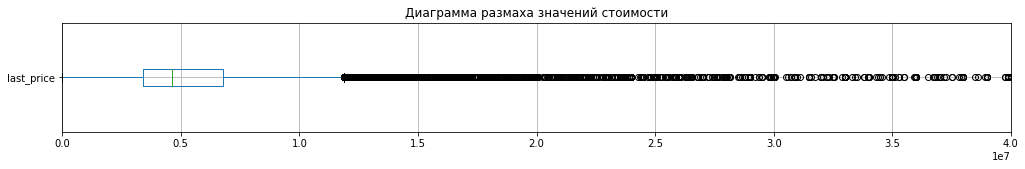

In [21]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['last_price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений стоимости')
ax.set_xlim(0, 40000000);

In [22]:
# Удалим все значения больше 25 000 000
data = data[data['last_price'] < 25000000]


In [23]:
#check
print(data['last_price'].count())

23121


##### Столбец общая площадь:

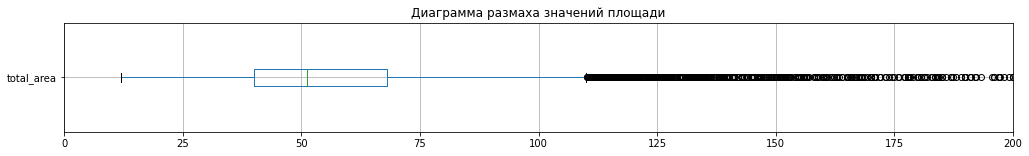

In [24]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 200);

In [25]:
# Удалим все значения больше 120 и меньше 24 м
data = data[(data['total_area'] < 180) & (data['total_area'] > 24)]

In [26]:
#check
print(len(data['last_price']))

22852


In [27]:
# check
import matplotlib.pyplot as plt

##### Столбец жилая площадь:

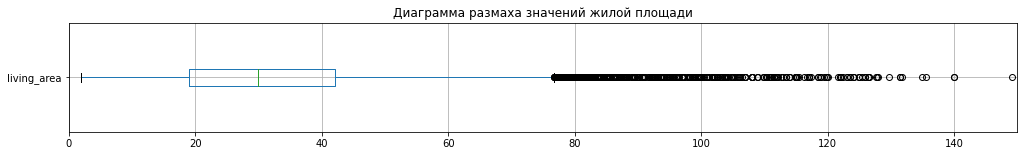

In [29]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений жилой площади')
ax.set_xlim(0,150);

In [30]:
# Удалим все значения больше 130
data = data[(data['living_area'] < 130) & (data['living_area'] > 10)]

##### Столбец площадь кухни:

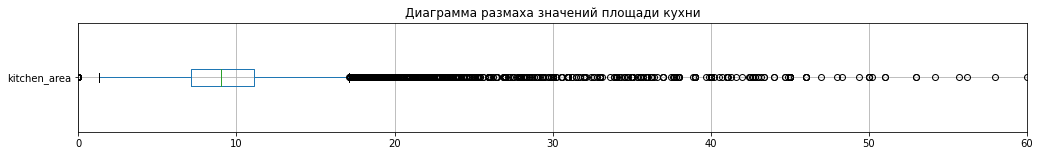

In [31]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['kitchen_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади кухни')
ax.set_xlim(0,60);

In [32]:
# Удалим все значения больше 30 и меньше 4 м.кв.
data = data[(data['kitchen_area'] < 30) & (data['kitchen_area'] > 4)]

Столбец этаж:

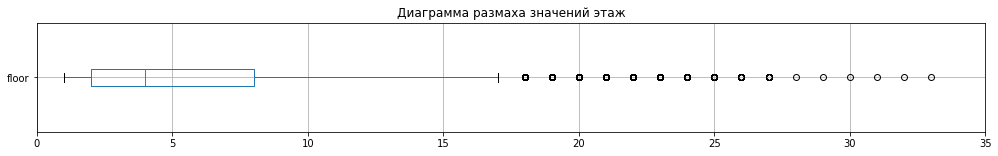

In [33]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['floor']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений этаж')
ax.set_xlim(0,35);

In [34]:
# Удалим данные этажности больше 30 этажа
data = data[data['floor'] < 30]

In [35]:
#check
print(len(data['last_price']))

22422


##### Столбец общее количество этажей.

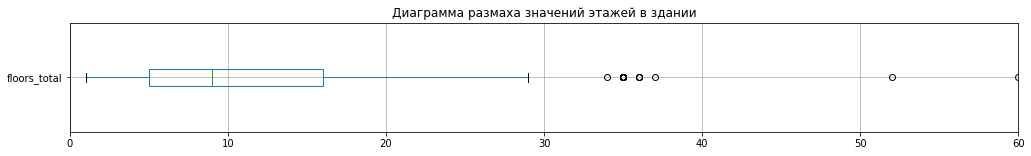

In [36]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['floors_total']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений этажей в здании')
ax.set_xlim(0,60);

In [37]:
#  Удалим данный этажности больше 30 этажа
data = data[data['floors_total'] < 30]

In [38]:
#check
print(len(data['last_price']))

22395


##### Столбец количестов комнат.

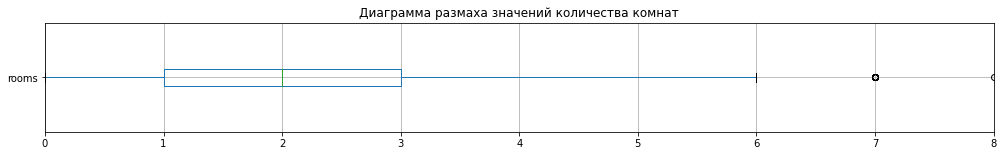

In [39]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['rooms']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений количества комнат')
ax.set_xlim(0,8);

In [40]:
#  Удалим данные с количеством комнат больше 7.
data = data[data['rooms'] < 8]

In [41]:
#check
print(len(data['last_price']))

22394


##### Столбец скорость продажи: 

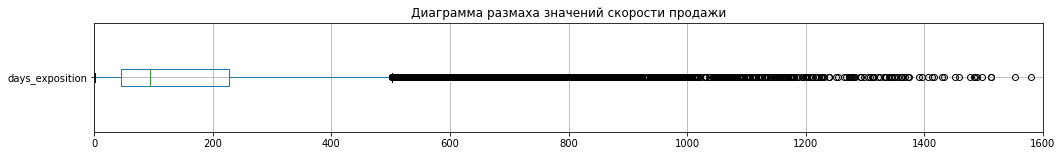

In [42]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['days_exposition']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений скорости продажи')
ax.set_xlim(0,1600);

Посколльку в столбце days_exposition  есть пропуски, считается что эти крватиры еще находится в продаже. Соответсвенно удалять строки по признаку скорости продажи не будем.

In [43]:
#check
print(len(data['last_price']))

22394


##### Столбец высота потолков:

- В стоблце высота потолков 'ceiling_height' есть анамальные значения высот потолков больше 20 м и сильно меньше 1 м.
- Заполним пустые значени медианой.
- Удалим все значени с потолками меньше 2,4 м и больше 4.

In [44]:
column = 'ceiling_height'

#рассмотрим сколько в таблице значений больше 20 м.
filter_1 = data['ceiling_height'] >= 20
data.loc[filter_1, column] = data.loc[filter_1, column]/10

#рассмотрим сколько в таблице значений меньше 0.001 м. 
filter_2 = data['ceiling_height'] < 0.001
data.loc[filter_2, column] = data.loc[filter_2, column]*10000

In [45]:
#медиана высоты потолков
ceiling_height_median = data['ceiling_height'].median()
#земеним пустые ячейки медианой высоты потолков
data['ceiling_height'] = data['ceiling_height'].fillna(value=ceiling_height_median)

In [46]:
#удалим строки с высотой потолков меньше 2.4 м и больше 4 м
data = data[(data['ceiling_height']>2.4) & (data['ceiling_height']<4)]

##### Промежуточный Вывод: 
- Заполнил пропуски в столбцах, в которых представлялось возможными.
- Столбцы с указанеим географических мест и расстояний оставлены без изменений.

In [47]:
# вызовек функцию, чтобы посмотреть как изменилась исходная таблица по пропускам
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5333
cityCenters_nearest      5315
parks_around3000         5314
parks_nearest           14916
ponds_around3000         5314
ponds_nearest           13996
days_exposition          2900
dtype: int64

In [48]:
# вызовем функцию инфо, чтобы посмотреть как изменилась исходная таблица
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22286 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22286 non-null  int64         
 1   last_price            22286 non-null  float64       
 2   total_area            22286 non-null  float64       
 3   first_day_exposition  22286 non-null  datetime64[ns]
 4   rooms                 22286 non-null  int64         
 5   ceiling_height        22286 non-null  float64       
 6   floors_total          22286 non-null  float64       
 7   living_area           22286 non-null  float64       
 8   floor                 22286 non-null  int64         
 9   is_apartment          22286 non-null  bool          
 10  studio                22286 non-null  bool          
 11  open_plan             22286 non-null  bool          
 12  kitchen_area          22286 non-null  float64       
 13  balcony         

In [49]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,286.00","22,286.00","22,286.00","19,386.00","22,286.00","22,286.00","22,286.00","22,286.00","22,286.00"
min,0.00,24.20,2.45,1.00,"430,000.00",10.08,4.10,1.00,1.00
max,7.00,179.70,3.98,"1,580.00","24,900,000.00",129.68,29.90,27.00,29.00


In [50]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,7785
2,7717
3,5489
4,987
5,211
0,44
6,40
7,13


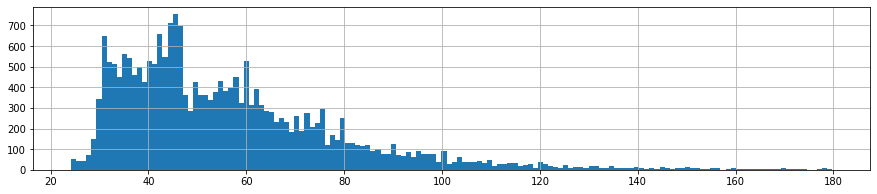

In [51]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

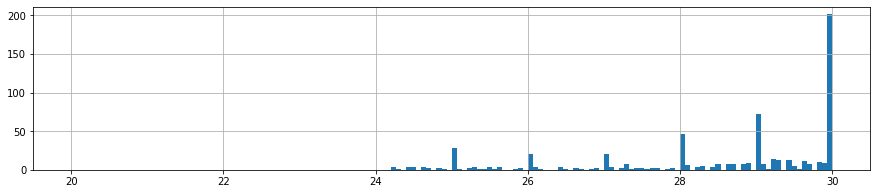

In [52]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (20,30));

In [53]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.010000,1.00,28.60,2.50,4.00,"1,000,000.00",13.73,5.00,1.00,2.00
0.500000,2.00,51.00,2.65,94.00,"4,577,500.00",30.00,9.01,4.00,9.00
0.900000,3.00,86.00,2.90,450.00,"9,500,000.00",53.10,14.40,13.00,22.00
0.997600,5.00,162.61,3.70,"1,292.48","22,500,000.00",111.73,27.90,25.00,27.00


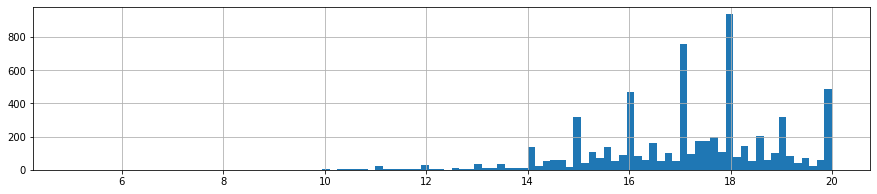

In [54]:
# check
data.living_area.hist(bins = 100, figsize = (15,3), range = (5,20));

### Посчитайте и добавьте в таблицу новые столбцы

#### Цена одного квадратного метра

In [55]:
# расчитаем стоиомтсь квадратного метра
data['price_per_squere_metre'] = data['last_price'] / data['total_area']

#### День недели публикации объявления

In [56]:
data['weekday'] = data['first_day_exposition'].dt.weekday
print(data['weekday'].value_counts()) 

3    4006
1    3952
4    3779
2    3728
0    3387
5    1830
6    1604
Name: weekday, dtype: int64


#### Месяц публикации объявления

In [57]:
data['month'] = data['first_day_exposition'].dt.month
print(data['month'].value_counts()) 

2     2501
3     2441
4     2237
11    2228
10    2006
9     1873
6     1668
8     1635
7     1567
12    1542
1     1401
5     1187
Name: month, dtype: int64


#### Год публикации объявления

In [58]:
data['year'] = data['first_day_exposition'].dt.year
print(data['year'].value_counts()) 

2018    8065
2017    7713
2019    2717
2016    2599
2015    1079
2014     113
Name: year, dtype: int64


#### Тип этажа квартиры

In [59]:
#создадим функцию для создания столбца по типу этажа
def floor_category(row):
    floor=row['floor']
    floors_total=row['floors_total']
    try:
        if floor == 1:
            return 'первый'
        elif floor == floors_total:
            return 'последний'
        else:
            return 'другой'
    except:
        pass

In [60]:
# применим функцию и создаим новый столбец
data['floor_category'] = data.apply(floor_category, axis=1)
print(data['floor_category'].value_counts())

другой       16389
последний     3107
первый        2790
Name: floor_category, dtype: int64


#### Расстояние до центра города в километрах

In [61]:
#создадим функцию для создания столбца по типу этажа
def cityCenters_nearest_km(cityCenters_nearest):
    try:
        distance = round(cityCenters_nearest / 1000)
        return distance
    except:
        pass

In [62]:
# применим функцию и создаим новый столбец расстояние до центра в киллометрах
data['cityCenters_nearest_km'] = data['cityCenters_nearest'].apply(cityCenters_nearest_km)

#### Промежуточный Вывод: 

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22286 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            22286 non-null  int64         
 1   last_price              22286 non-null  float64       
 2   total_area              22286 non-null  float64       
 3   first_day_exposition    22286 non-null  datetime64[ns]
 4   rooms                   22286 non-null  int64         
 5   ceiling_height          22286 non-null  float64       
 6   floors_total            22286 non-null  float64       
 7   living_area             22286 non-null  float64       
 8   floor                   22286 non-null  int64         
 9   is_apartment            22286 non-null  bool          
 10  studio                  22286 non-null  bool          
 11  open_plan               22286 non-null  bool          
 12  kitchen_area            22286 non-null  float6

### Проведите исследовательский анализ данных

#### Рассмотрим параметры объектов:

##### Общая площадь:

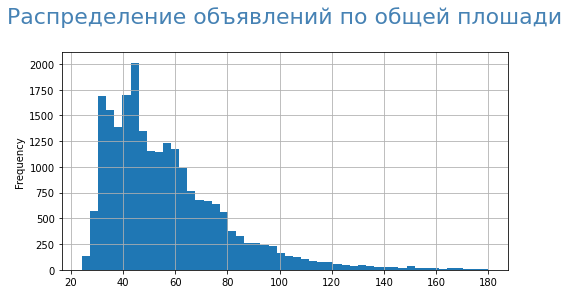

In [64]:
#построим гистограмму для всех значений
(
    data
    .plot(y='total_area',kind='hist',bins = 50,figsize=(8,4),grid=True, legend=False)
    .set_title('Распределение объявлений по общей плошади' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: Основной объем данных приходится на общую площадь в диапозоне 30-80 м.кв.

##### Жилая площадь:

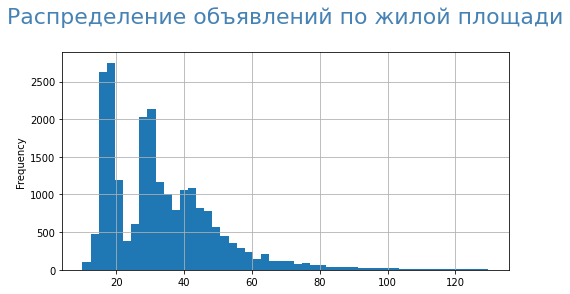

In [65]:
#построим гистограмму для всех значений
(
    data
    .plot(y='living_area',kind='hist',bins = 50,figsize=(8,4),grid=True,legend=False)
    .set_title('Распределение объявлений по жилой площади' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: Основной объем данных приходится на жилую площадь 20 - 40 м.кв.

##### Площадь кухни:

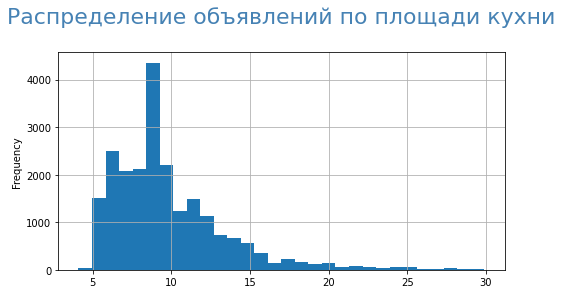

In [66]:
#построим гистограмму для всех значений
(
    data
    .plot(y='kitchen_area',kind='hist',bins = 30,figsize=(8,4),grid=True,legend=False)
    .set_title('Распределение объявлений по площади кухни' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: Основной объем данных приходится на общую площадь в диапозоне 5-15 м.кв. Так же из гистограммы видно, что квартиры с площадью кухни больше 25м.кв. можно убрать из дальнейшего анализа.

##### Цена объекта:

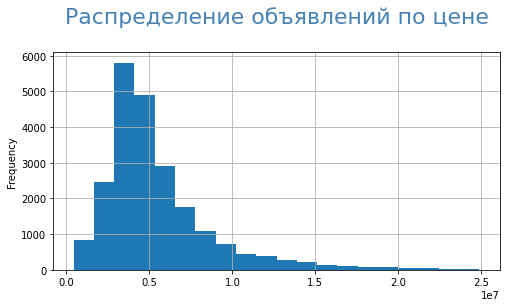

In [67]:
#построим гистограмму для всех значений
(
    data
    .plot(y='last_price',kind='hist',bins = 20,figsize=(8,4),grid=True,legend=False)
    .set_title('Распределение объявлений по цене' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: основной объем данных лежит в диапозоне стоимости от 1-10 млн.

##### Количество комнат:

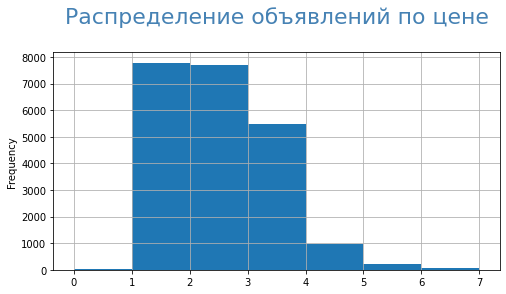

In [68]:
#построим гистограмму для всех значений
(
    data
    .plot(y='rooms',kind='hist',bins = 7,figsize=(8,4),grid=True,legend=False)
    .set_title('Распределение объявлений по цене' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: самый распростронненые квартиры 2-4 комнаты.

##### Высота потолков:

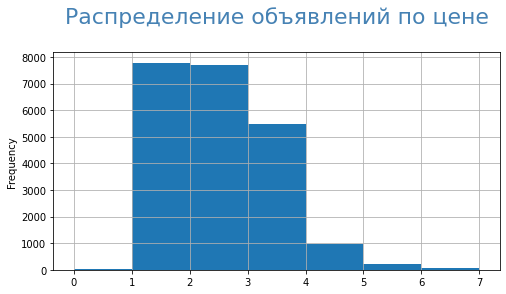

In [69]:
#построим гистограмму для всех значений
(
    data
    .plot(y='rooms',kind='hist',bins = 7,figsize=(8,4),grid=True,legend=False)
    .set_title('Распределение объявлений по цене' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: Объявлений квартир со стандартной высотой потолков 2,5 м больше всего.

##### Этаж квартиры:

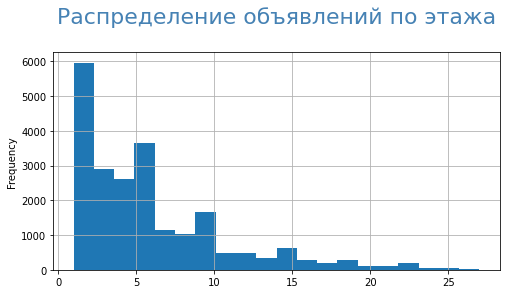

In [70]:
#построим гистограмму для всех значений
(
    data
    .plot(y='floor',kind='hist',bins = 20,figsize=(8,4),grid=True,legend=False)
    .set_title('Распределение объявлений по этажа' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: основная масса кравтир располагаются на 1-5 этажах.

##### Тип этажа квартиры («первый», «последний», «другой»):

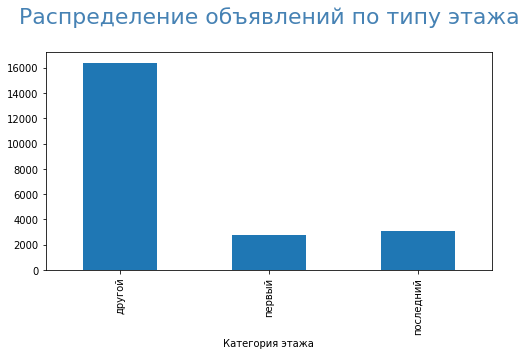

In [71]:
#построим график для всех значений
(
data
    .groupby('floor_category')['floor_category'].count()
    .plot(kind='bar', legend=False, figsize=(8,4), xlabel='Категория этажа')
    .set_title('Распределение объявлений по типу этажа' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: большего всего квартир на средних этажах. Кол-во обявление на 1-м и последних этажах близко друг к другу.

##### Общее количество этажей в доме:
 

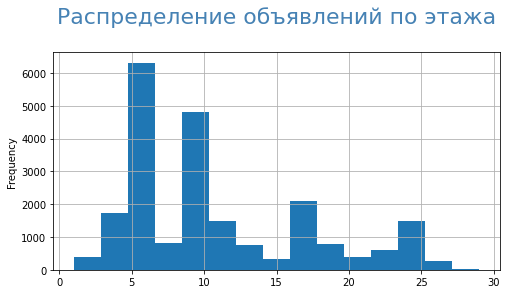

In [72]:
#построим гистограмму для всех значений
(
    data
    .plot(y='floors_total',kind='hist',bins = 15,figsize=(8,4),grid=True,legend=False)
    .set_title('Распределение объявлений по этажа' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: самые распростронненные дома 5 и 10 этажей. При увеличении этажей в доме количество объявлений снижается, так как, таких домов существенно меньше, чем в 5-10 этажей

##### Расстояние до центра города в метрах:

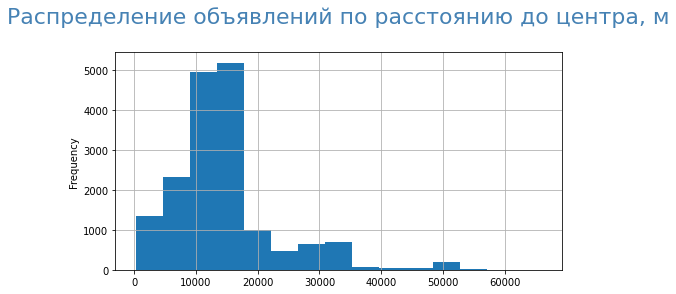

In [73]:
#построим гистограмму для всех значений
(
    data
    .plot(y='cityCenters_nearest',kind='hist',bins = 15,figsize=(8,4),grid=True,legend=False)
    .set_title('Распределение объявлений по расстоянию до центра, м' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: большая часть недвижимости находится в пределах 20 км от центра. Есть объекты в пределах 40 км. Можно было бы удалить объекты за пределами 40 км, но данных в этом с толбце и так мало. Пока оставим так.

##### Расстояние до ближайшего аэропорта:


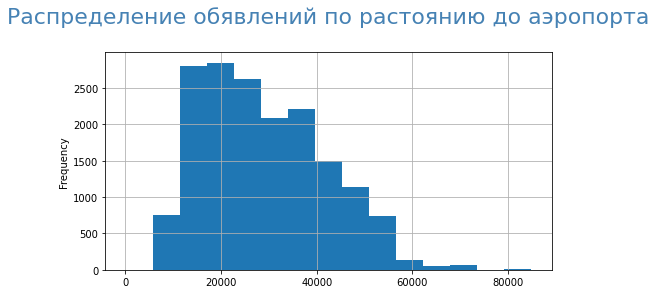

In [74]:
#построим гистограмму для всех значений
(
    data
    .plot(y='airports_nearest',
          kind='hist',
          bins = 15,
          figsize=(8,4),
          grid=True,
          legend=False)
    .set_title('Распределение обявлений по растоянию до аэропорта' + "\n", fontsize = 22, color = 'SteelBlue')
);

Большинство объектов недвижимости лежат в радиусе 50 км от аэропорта. Объекты дальше 70 км можно было удалить.

##### Расстояние до ближайшего парка:

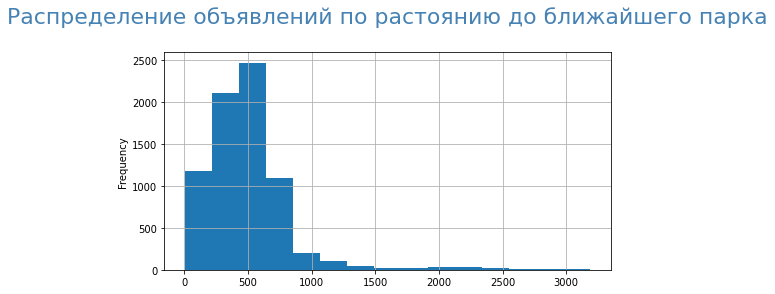

In [75]:
#построим гистограмму для всех значений
(
    data
    .plot(y='parks_nearest',kind='hist',bins = 15,figsize=(8,4),grid=True,legend=False)
    .set_title('Распределение объявлений по растоянию до ближайшего парка' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод: большая часть объектов лежит в радиусе 1000 км. Данными больше 2500 можно было бы пренебречь.

##### День публикации объявления:

Text(0.5, 1.0, 'Распределение обявлений по дню недели публикации\n')

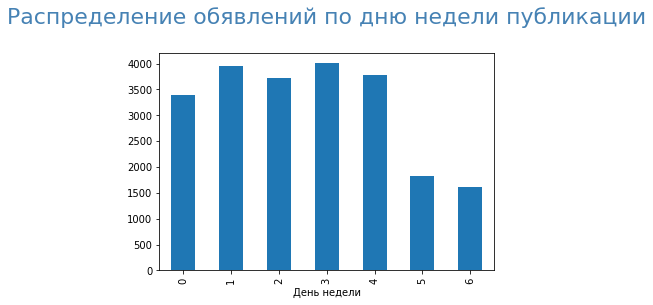

In [76]:
#построим гистограмму для всех значений
(
data
    .groupby('weekday')['weekday'].count()
    .plot(kind='bar', xlabel='День недели')
    .set_title('Распределение обявлений по дню недели публикации' + "\n", fontsize = 22, color = 'SteelBlue')
)

Вывод: Из графика видно, что активность людей по размещению объявлений в рабочии дни существенно выше, чем в выходные.

##### Месяц публикации объявления:

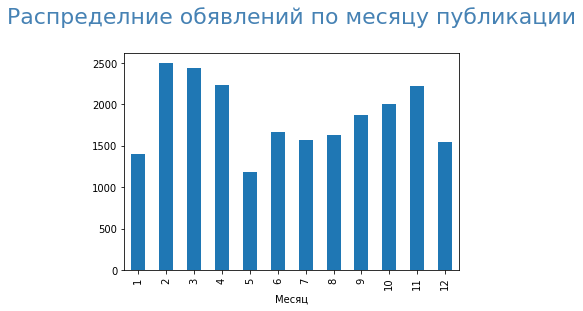

In [77]:
#построим гистограмму для всех значений
(
data
    .groupby('month')['month'].count()
    .plot(kind='bar', xlabel='Месяц')
    .set_title('Распределние обявлений по месяцу публикации' + "\n", fontsize = 22, color = 'SteelBlue')
    
);

##### Промежуточный Вывод: 
Из гистограммы видно, что
- активность людей по размещению объявлений приходится на февраль-апрель,
- после этого происходит спад,
- ближе к осени наблюдается рост активности.

#### Исследование как быстро продовались квартиры.

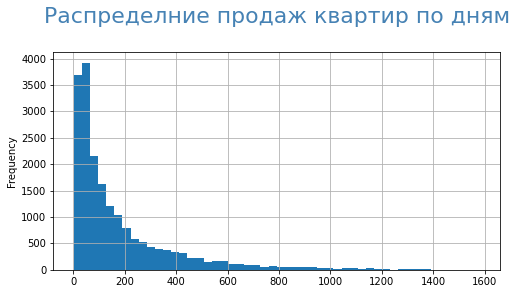

In [78]:
# построим гистограмму
(
    data
    .plot(y='days_exposition',
          kind='hist',
          bins = 50,
          figsize=(8,4),
          grid=True,
          legend=False
         )
    .set_title('Распределние продаж квартир по дням' + "\n", fontsize = 22, color = 'SteelBlue')
);
    

In [79]:
# расчитем среднее
print('Среднее времени продаж:', round(data['days_exposition'].mean()))

Среднее времени продаж: 178


In [80]:
# расчитем медиану
print('Медиана времени продаж:',data['days_exposition'].median())

Медиана времени продаж: 94.0


In [81]:
data['days_exposition'].describe()

count    19386.000000
mean       178.216239
std        216.268258
min          1.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

##### Промежуточный Вывод: 
- Обычная скорость продажи квартиры составляет от 45 до 228 дней.
- Если продажа осуществилась быстрее 45 дней это быстрая продажа.
- Если объект недвижимости не удется продать за 500 дней это уже долгая продажа.

#### Исследование какие факторы больше всего влияют на общую (полную) стоимость объекта.

##### Зависимость стоимости от общей площади:

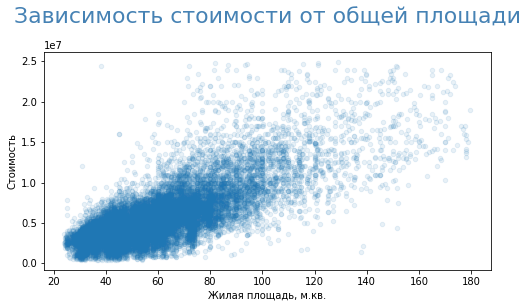

In [82]:
#построи диаграмму рассейния
(
    data
    .plot(x='total_area',
          y='last_price',
          kind='scatter',
          figsize=(8,4),
          alpha=0.1,
          xlabel='Жилая площадь, м.кв.',
          ylabel='Стоимость',
          legend=False)
    .set_title('Зависимость стоимости от общей площади' + "\n", fontsize = 22, color = 'SteelBlue')
);

In [83]:
#Найдем коэффициент корреляции
print(data['total_area'].corr(data['last_price']))

0.7680206898576187


Вывод: зависимость между ценой и площадью существует. Чем больше площадь тем больше цена.

##### Зависимость стоимости от жилой площади:

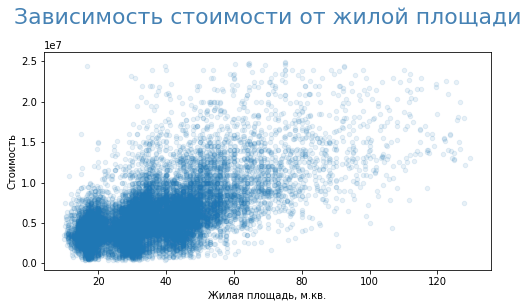

In [84]:
(
    data
    .plot(x='living_area',
          y='last_price',
          kind='scatter',
          figsize=(8,4),
          alpha=0.1,
          xlabel='Жилая площадь, м.кв.',
          ylabel='Стоимость',
          legend=False)
    .set_title('Зависимость стоимости от жилой площади' + "\n", fontsize = 22, color = 'SteelBlue')
);

In [85]:
print(data['living_area'].corr(data['last_price']))

0.6626534012248072


Вывод: зависимость между ценой и жилой площадью существует, но не такая ярко выраженная. Чем больше площадь, тем больше цена.

##### Зависимость стоимости от площади кухни:

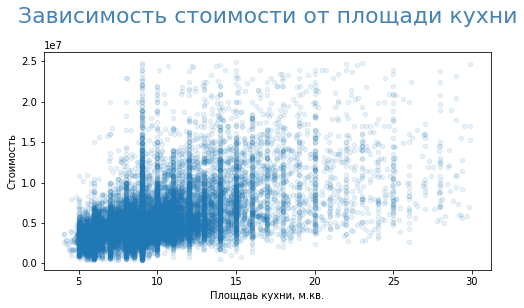

In [86]:
(
    data
    .plot(x='kitchen_area',
          y='last_price',
          kind='scatter',
          figsize=(8,4),
          alpha=0.1,
          xlabel='Площдаь кухни, м.кв.',
          ylabel='Стоимость',
          legend=False)
    .set_title('Зависимость стоимости от площади кухни' + "\n", fontsize = 22, color = 'SteelBlue')
);

In [87]:
print(data['kitchen_area'].corr(data['last_price']))

0.5350741118401278


Вывод: зависимость между ценой и площадью кухни существует.

##### Зависимость стоимости от количества комнат:

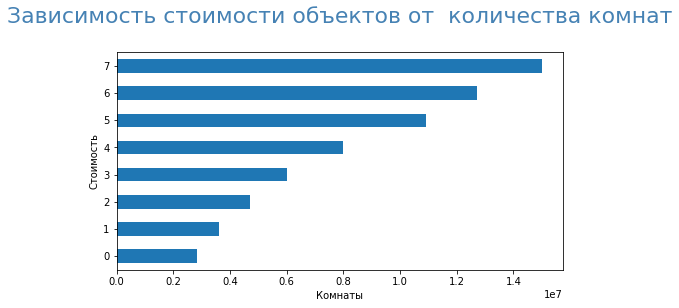

In [88]:
(
    data
    .pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(kind='barh', figsize=(8,4), xlabel='Комнаты', ylabel='Стоимость', legend=False)
    .set_title('Зависимость стоимости объектов от  количества комнат' + "\n", fontsize = 22, color = 'SteelBlue')
);

In [89]:
print(data['rooms'].corr(data['last_price']))

0.4856552588988745


Вывод: зависимость между ценой и количеством комнат существует.

##### Зависимость стоимости от этажа, на котором расположена квартира:

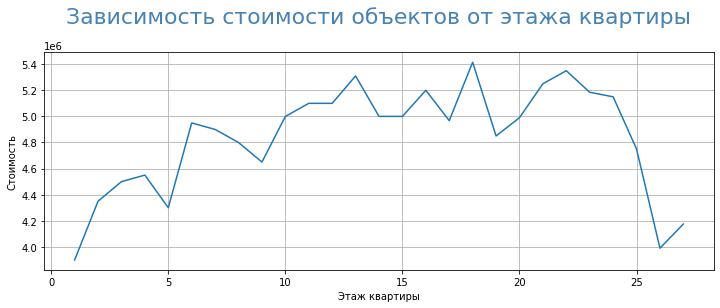

In [90]:
(
    data
    .pivot_table(index='floor', values='last_price', aggfunc='median')
    .plot(figsize=(12,4), grid=True, xlabel='Этаж квартиры', ylabel='Стоимость', legend=False)
    .set_title('Зависимость стоимости объектов от этажа квартиры' + "\n", fontsize = 22, color = 'SteelBlue')
);

In [91]:
print(data['last_price'].corr(data['floor']))

0.09309826340794378


Вывод: зависимость между ценой и количеством комнат существует, но очень слабая.

##### Зависимость стоимости от типа этажа, на котором расположена квартира (первый, последний, другой):

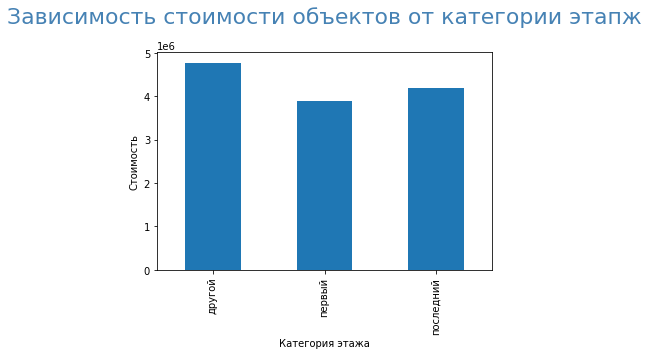

In [92]:
(
    data
    .pivot_table(index='floor_category', values='last_price', aggfunc='median')
    .plot(kind='bar', xlabel='Категория этажа', ylabel='Стоимость', legend=False)
    .set_title('Зависимость стоимости объектов от категории этапж' + "\n", fontsize = 22, color = 'SteelBlue')
);

Вывод:
- самые дешовые квартиры располагаются на первом этаже;
- немного дороже квартиры на послденем этаже;
- квартиры на дргуих этажах оцениваются дороже.

##### Зависимость стоимости от даты размещения день недели:

Text(0.5, 1.0, 'Зависимость стоимости объектов от дня недели публикации\n')

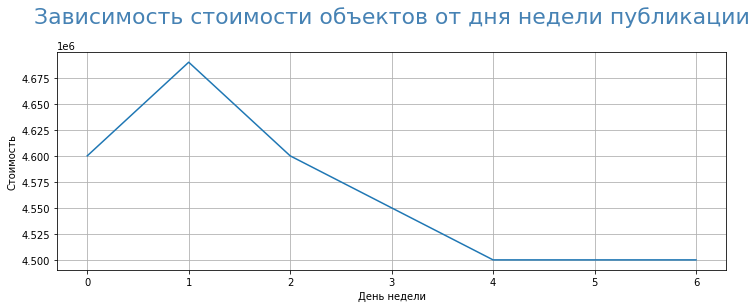

In [93]:
(
    data
    .pivot_table(index='weekday', values='last_price', aggfunc='median')
    .plot(figsize=(12,4), grid=True, xlabel='День недели', ylabel='Стоимость', legend=False)
    .set_title('Зависимость стоимости объектов от дня недели публикации' + "\n", fontsize = 22, color = 'SteelBlue')
)

Вывод: Цена не зависит от дня недели публикации

##### Зависимость стоимости от даты размещения месяц:

Text(0.5, 1.0, 'Зависимость стоимости объектов от месяца публикации\n')

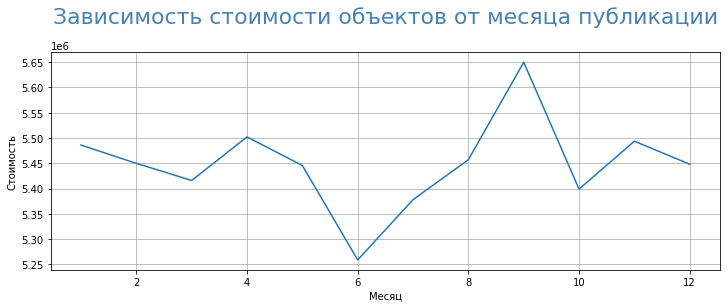

In [94]:
(
    data
    .pivot_table(index='month', values='last_price', aggfunc='mean')
    .plot(figsize=(12,4), grid=True, xlabel='Месяц', ylabel='Стоимость', legend=False)
    .set_title('Зависимость стоимости объектов от месяца публикации' + "\n", fontsize = 22, color = 'SteelBlue') 
)

Вывод: Цена не зависит от месяца публикации.

##### Зависимость стоимости от даты размещения год:

Построим график зависимости стоимости от цены размещения

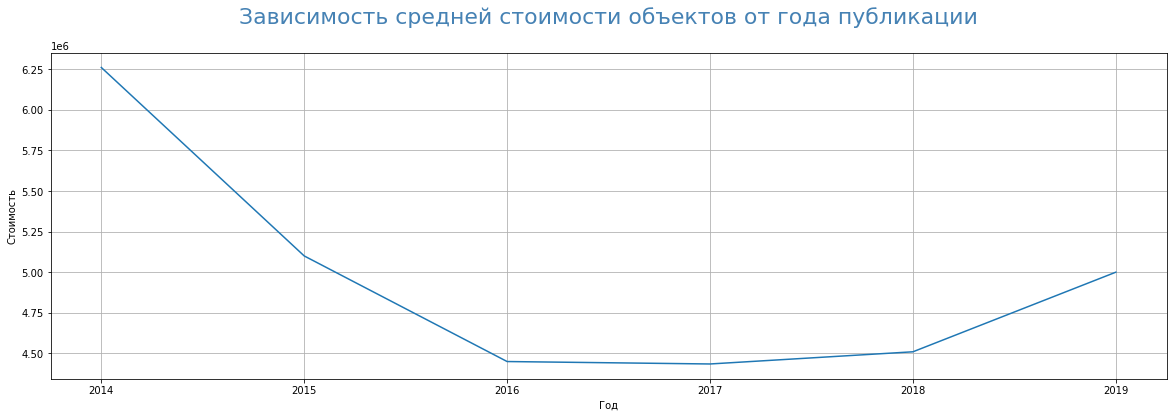

In [95]:
(
    data
    .pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(figsize=(20,6), grid=True, xlabel='Год', ylabel='Стоимость', legend=False)
    .set_title('Зависимость средней стоимости объектов от года публикации' + "\n", fontsize = 22, color = 'SteelBlue') 
);

Построим график зависимости стоимости от количества квадратных метров

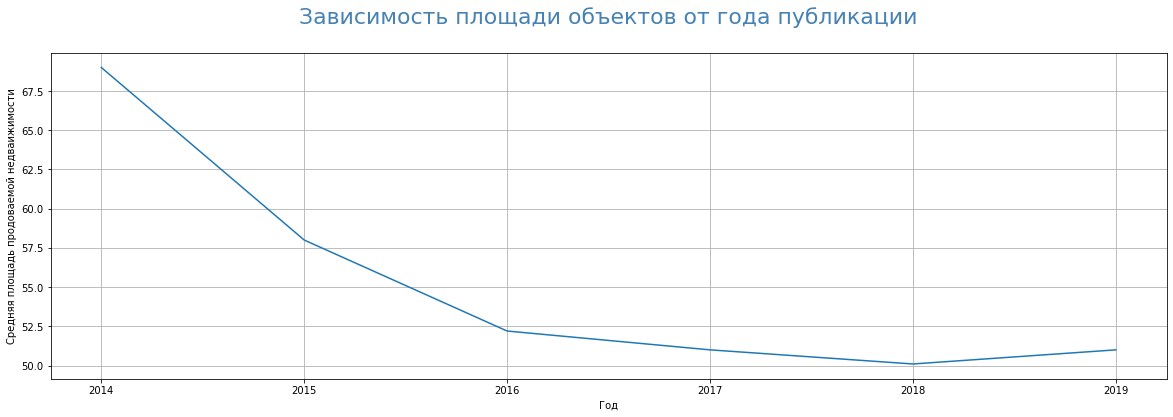

In [96]:
(
    data
    .pivot_table(index='year', values='total_area', aggfunc='median')
    .plot(figsize=(20,6), grid=True, xlabel='Год', ylabel='Средняя площадь продоваемой недваижимости', legend=False)
    .set_title('Зависимость площади объектов от года публикации' + "\n", fontsize = 22, color = 'SteelBlue') 
);

Вывод:
- Снижеение цены от года обусловлено тем, что изменялось среднее значение общей площади продаваемой недвижимости.
- Прямой зависимости цены от года публикации нет.

##### Промежучтоный вывод:
- Наибольшее влияние на цену оказывают:
    - общая площадь,
    - жилай площадь,
    - площадь кухни,
    - количество комнат,
    - этаж.
- Не оказывают влияние на цену:
    - месяц,
    - день недели,
    - года.

#### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [97]:
#состаим список из 10 населенных пунктов с самым большим количество объявлений
data['locality_name'].value_counts().head(10)

Санкт-Петербург      14571
поселок Мурино         509
поселок Шушары         429
Всеволожск             383
Пушкин                 348
Колпино                335
поселок Парголово      324
Гатчина                305
деревня Кудрово        283
Выборг                 225
Name: locality_name, dtype: int64

In [98]:
# соберем сводную таблтцу по названию населеного пункта и расчитаем среднюю стоимость квадратного метра и общее количество обявлений
locality_name_stаt = data.pivot_table(index='locality_name', values='price_per_squere_metre', aggfunc=['mean', 'count'])
# переименуем названия столбцов
locality_name_stаt.columns = ['mean_price', 'count']
# оставим только 10 населенных пунктов с самым большим количеством обявлений
good_locality_name_stаt = locality_name_stаt.sort_values(by='count',ascending=False).head(10)
# выведем на экран таблтцу
display(good_locality_name_stаt)

,mean_price,count
locality_name,,
Санкт-Петербург,108963.694744,14571
поселок Мурино,84597.118628,509
поселок Шушары,78123.811826,429
Всеволожск,68541.539391,383
Пушкин,101822.989357,348
Колпино,75258.548102,335
поселок Парголово,90401.186457,324
Гатчина,68729.885843,305
деревня Кудрово,92229.683659,283


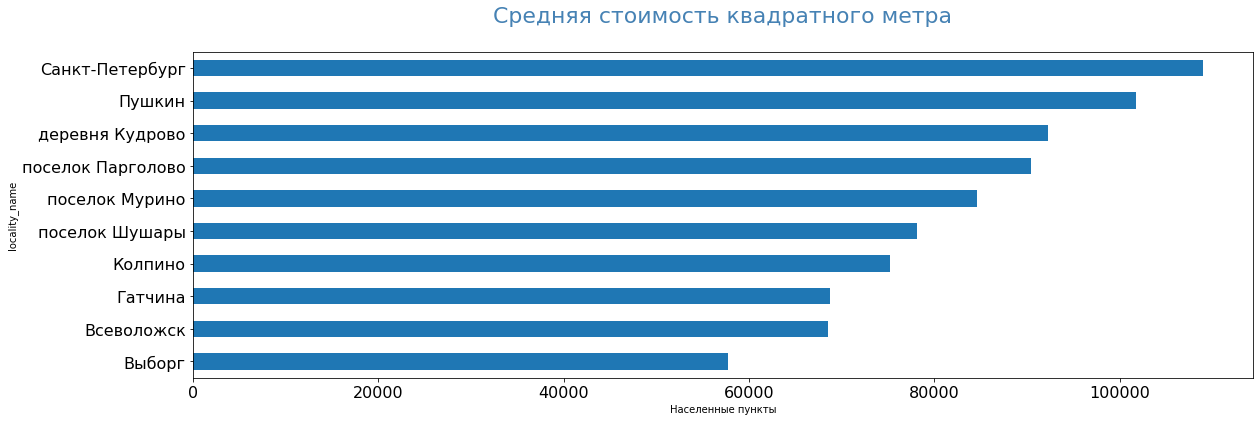

In [99]:
(
    good_locality_name_stаt.sort_values(by='mean_price',ascending=True)['mean_price']
    .head(10)
    .plot(kind= 'barh', figsize=(19,6),  fontsize = 16, xlabel='Населенные пункты')
    .set_title('Средняя стоимость квадратного метра' + "\n", fontsize = 22, color = 'SteelBlue') 
);

In [100]:
# найдем  и выведем на экран среднее значение квадратного метра для выборки из 10 населенных пунктов
print('Средняя цена квадратного метра:', round(good_locality_name_stаt['mean_price'].mean()))

Средняя цена квадратного метра: 82644


In [101]:
# найдем  и выведем на экран минимальное значение квадратного метра для выборки из 10 населенных пунктов
print('Минимальная цена:',round(good_locality_name_stаt['mean_price'].min()))

Минимальная цена: 57774


In [102]:
# найдем  и выведем на экран максимальное среднее значение квадратного метра для выборки из 10 населенных пунктов
print('Максимальная цена:',round(good_locality_name_stаt['mean_price'].max()))

Максимальная цена: 108964


#### Квартиры в Санкт-Петербурге.

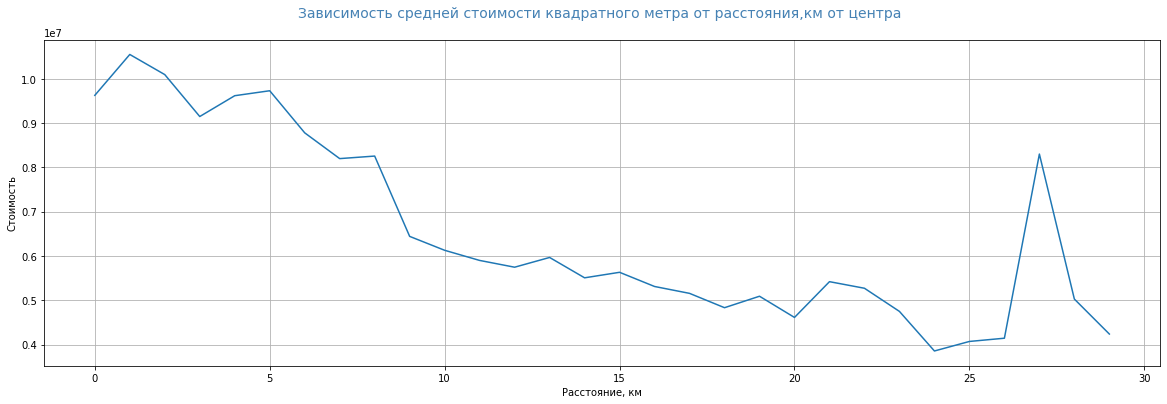

In [103]:
(
    data
    .query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc=['mean'])
    .plot(figsize=(20,6), grid=True, xlabel='Расстояние, км', ylabel='Стоимость', legend=False)
    .set_title('Зависимость средней стоимости квадратного метра от расстояния,км от центра ' + "\n", fontsize = 14, color = 'SteelBlue') 
);

### Общий вывод

1. Влияние на цену параметров объекта недвижимости:
- Наибольшее влияние на цену оказывают:
    - общая площадь,
    - жилай площадь,
    - площадь кухни,
    - количество комнат,
    - этаж.
- Не оказывают влияние на цену:
    - месяц,
    - день недели, 
    - год.

2. Расчитаны цены для 10 населеных пунктов с самым большим количеством обявлений
- средняя цена 82 644,
- минимальная цена 57 774,
- максимальная цена 108 964.

3. Средняя стоимость каждого километра в Санкт-Петербурге уменьшается по мере удаления от центра города. 